In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path("E:/EpiSight")
RAW_DATA = PROJECT_ROOT / "data" / "raw"
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"

print("Chargement des données brutes...")

# Rechargement propre des 3 datasets
df_tests = pd.read_csv(RAW_DATA / "sp_tests_quotidiens.csv", sep=';', decimal=',', low_memory=False)
df_hosp  = pd.read_csv(RAW_DATA / "sp_hospitalisations.csv", sep=';', decimal=',', low_memory=False)
df_vacc  = pd.read_csv(RAW_DATA / "sp_vaccination.csv",      sep=';', decimal=',', low_memory=False)

print(f"Tests        : {df_tests.shape[0]:,} lignes")
print(f"Hospitalisations : {df_hosp.shape[0]:,} lignes")
print(f"Vaccination  : {df_vacc.shape[0]:,} lignes")

Chargement des données brutes...
Tests        : 118,626 lignes
Hospitalisations : 338,245 lignes
Vaccination  : 1,430,670 lignes


In [2]:
print("NETTOYAGE — TESTS VIROLOGIQUES")
print("=" * 50)

# 1. Filtre tous âges confondus (évite double comptage)
df_tests = df_tests[df_tests['cl_age90'] == 0].copy()

# 2. Conversion date
df_tests['jour'] = pd.to_datetime(df_tests['jour'])

# 3. Colonnes numériques utiles (déjà float64 grâce à decimal=',')
cols_num = ['P', 'T', 'Tp', 'pop']
for col in cols_num:
    df_tests[col] = pd.to_numeric(df_tests[col], errors='coerce')

# 4. Traitement des 306 valeurs manquantes dans Tp
# On les recalcule depuis P et T plutôt que de les supprimer
masque_tp_manquant = df_tests['Tp'].isna()
df_tests.loc[masque_tp_manquant, 'Tp'] = (
    df_tests.loc[masque_tp_manquant, 'P'] /
    df_tests.loc[masque_tp_manquant, 'T'] * 100
).round(2)

print(f"Valeurs manquantes Tp restantes : {df_tests['Tp'].isna().sum()}")

# 5. Garde uniquement les colonnes utiles
df_tests = df_tests[['dep', 'jour', 'pop', 'P', 'T', 'Tp']].copy()

# 6. Renomme
df_tests.rename(columns={
    'P': 'cas_positifs',
    'T': 'total_tests',
    'Tp': 'taux_positivite',
    'pop': 'population'
}, inplace=True)

print(f"Lignes après nettoyage : {len(df_tests):,}")
print(f"Période : {df_tests['jour'].min().date()} → {df_tests['jour'].max().date()}")
print(f"\nAperçu :")
print(df_tests.head(3).to_string())

NETTOYAGE — TESTS VIROLOGIQUES
Valeurs manquantes Tp restantes : 306
Lignes après nettoyage : 118,626
Période : 2020-05-13 → 2023-06-27

Aperçu :
  dep       jour  population  cas_positifs  total_tests  taux_positivite
0  01 2020-05-13    656955.0           9.0        340.0             2.65
1  01 2020-05-14    656955.0           9.0        440.0             2.05
2  01 2020-05-15    656955.0           5.0        454.0             1.10


In [3]:
print("NETTOYAGE — HOSPITALISATIONS")
print("=" * 50)

# 1. Filtre sexe == 0 (tous sexes confondus, évite double comptage)
df_hosp = df_hosp[df_hosp['sexe'] == 0].copy()

# 2. Conversion date
df_hosp['jour'] = pd.to_datetime(df_hosp['jour'])

# 3. Traitement NaN dans HospConv, SSR_USLD, autres
# Ces colonnes n'existaient pas au début de la pandémie → on remplace par 0
for col in ['HospConv', 'SSR_USLD', 'autres']:
    avant = df_hosp[col].isna().sum()
    df_hosp[col] = df_hosp[col].fillna(0)
    print(f"   {col} : {avant:,} NaN → remplacés par 0")

# 4. Garder les colonnes utiles et renommer
df_hosp = df_hosp[['dep', 'jour', 'hosp', 'rea', 'rad', 'dc']].copy()
df_hosp.rename(columns={
    'hosp': 'hospitalises',
    'rea'  : 'reanimation',
    'rad'  : 'retour_domicile',
    'dc'   : 'deces'
}, inplace=True)

print(f"\nLignes après nettoyage : {len(df_hosp):,}")
print(f"Période : {df_hosp['jour'].min().date()} → {df_hosp['jour'].max().date()}")
print(f"\nAperçu :")
print(df_hosp.head(3).to_string())

NETTOYAGE — HOSPITALISATIONS
   HospConv : 36,822 NaN → remplacés par 0
   SSR_USLD : 36,822 NaN → remplacés par 0
   autres : 36,822 NaN → remplacés par 0

Lignes après nettoyage : 113,118
Période : 2020-03-18 → 2023-03-31

Aperçu :
  dep       jour  hospitalises  reanimation  retour_domicile  deces
0  01 2020-03-18             2            0                1      0
3  02 2020-03-18            41           10               18     11
6  03 2020-03-18             4            0                1      0


In [4]:
print("NETTOYAGE — VACCINATION")
print("=" * 50)

# 1. Filtre tous âges confondus
df_vacc = df_vacc[df_vacc['clage_vacsi'] == 0].copy()

# 2. Conversion date
df_vacc['jour'] = pd.to_datetime(df_vacc['jour'])

# 3. Les colonnes couv_* sont en object (virgule décimale)
cols_couv = ['couv_dose1', 'couv_complet', 'couv_rappel']
for col in cols_couv:
    df_vacc[col] = df_vacc[col].astype(str).str.replace(',', '.', regex=False)
    df_vacc[col] = pd.to_numeric(df_vacc[col], errors='coerce')

# 4. Garder les colonnes utiles
df_vacc = df_vacc[[
    'dep', 'jour',
    'n_dose1', 'n_complet', 'n_rappel',
    'n_cum_dose1', 'n_cum_complet', 'n_cum_rappel',
    'couv_dose1', 'couv_complet', 'couv_rappel'
]].copy()

print(f"Lignes après nettoyage : {len(df_vacc):,}")
print(f"Période : {df_vacc['jour'].min().date()} → {df_vacc['jour'].max().date()}")
print(f"\nAperçu :")
print(df_vacc.head(3).to_string())

NETTOYAGE — VACCINATION
Lignes après nettoyage : 95,378
Période : 2020-12-27 → 2023-07-10

Aperçu :
        dep       jour  n_dose1  n_complet  n_rappel  n_cum_dose1  n_cum_complet  n_cum_rappel  couv_dose1  couv_complet  couv_rappel
1335292  01 2020-12-27        0          0         0            0              0             0         0.0           0.0          0.0
1335293  01 2020-12-28        1          1         0            1              1             0         0.0           0.0          0.0
1335294  01 2020-12-29        0          0         0            1              1             0         0.0           0.0          0.0


In [5]:
print("CALCUL DES MOYENNES MOBILES 7 JOURS")
print("=" * 50)

# Les données quotidiennes ont un "bruit de week-end" :
# moins de tests et de rapports le samedi/dimanche.
# La moyenne sur 7 jours glissants lisse ce bruit
# et révèle la tendance réelle de l'épidémie.

# Agrégation nationale tests
tests_nat = df_tests.groupby('jour').agg(
    cas_positifs=('cas_positifs', 'sum'),
    total_tests=('total_tests', 'sum')
).reset_index().sort_values('jour')

tests_nat['taux_positivite'] = (
    tests_nat['cas_positifs'] / tests_nat['total_tests'] * 100
).round(2)

# Moyenne mobile 7 jours (min_periods=1 pour ne pas perdre le début)
tests_nat['cas_mm7']  = tests_nat['cas_positifs'].rolling(7, min_periods=1).mean().round(0)
tests_nat['tp_mm7']   = tests_nat['taux_positivite'].rolling(7, min_periods=1).mean().round(2)

# Agrégation nationale hospitalisations
hosp_nat = df_hosp.groupby('jour').agg(
    hospitalises=('hospitalises', 'sum'),
    reanimation=('reanimation', 'sum'),
    deces=('deces', 'sum')
).reset_index().sort_values('jour')

hosp_nat['hosp_mm7'] = hosp_nat['hospitalises'].rolling(7, min_periods=1).mean().round(0)
hosp_nat['rea_mm7']  = hosp_nat['reanimation'].rolling(7, min_periods=1).mean().round(0)

print(f"Moyennes mobiles calculées")
print(f"\nAperçu tests nationaux :")
print(tests_nat[['jour','cas_positifs','cas_mm7','taux_positivite','tp_mm7']].tail(5).to_string())

CALCUL DES MOYENNES MOBILES 7 JOURS
Moyennes mobiles calculées

Aperçu tests nationaux :
           jour  cas_positifs  cas_mm7  taux_positivite  tp_mm7
1136 2023-06-23        1090.0   1160.0             8.76    7.98
1137 2023-06-24         619.0   1115.0             5.36    7.76
1138 2023-06-25         199.0   1109.0             5.47    7.71
1139 2023-06-26        1570.0   1053.0             7.95    7.62
1140 2023-06-27        1037.0    982.0             7.21    7.43


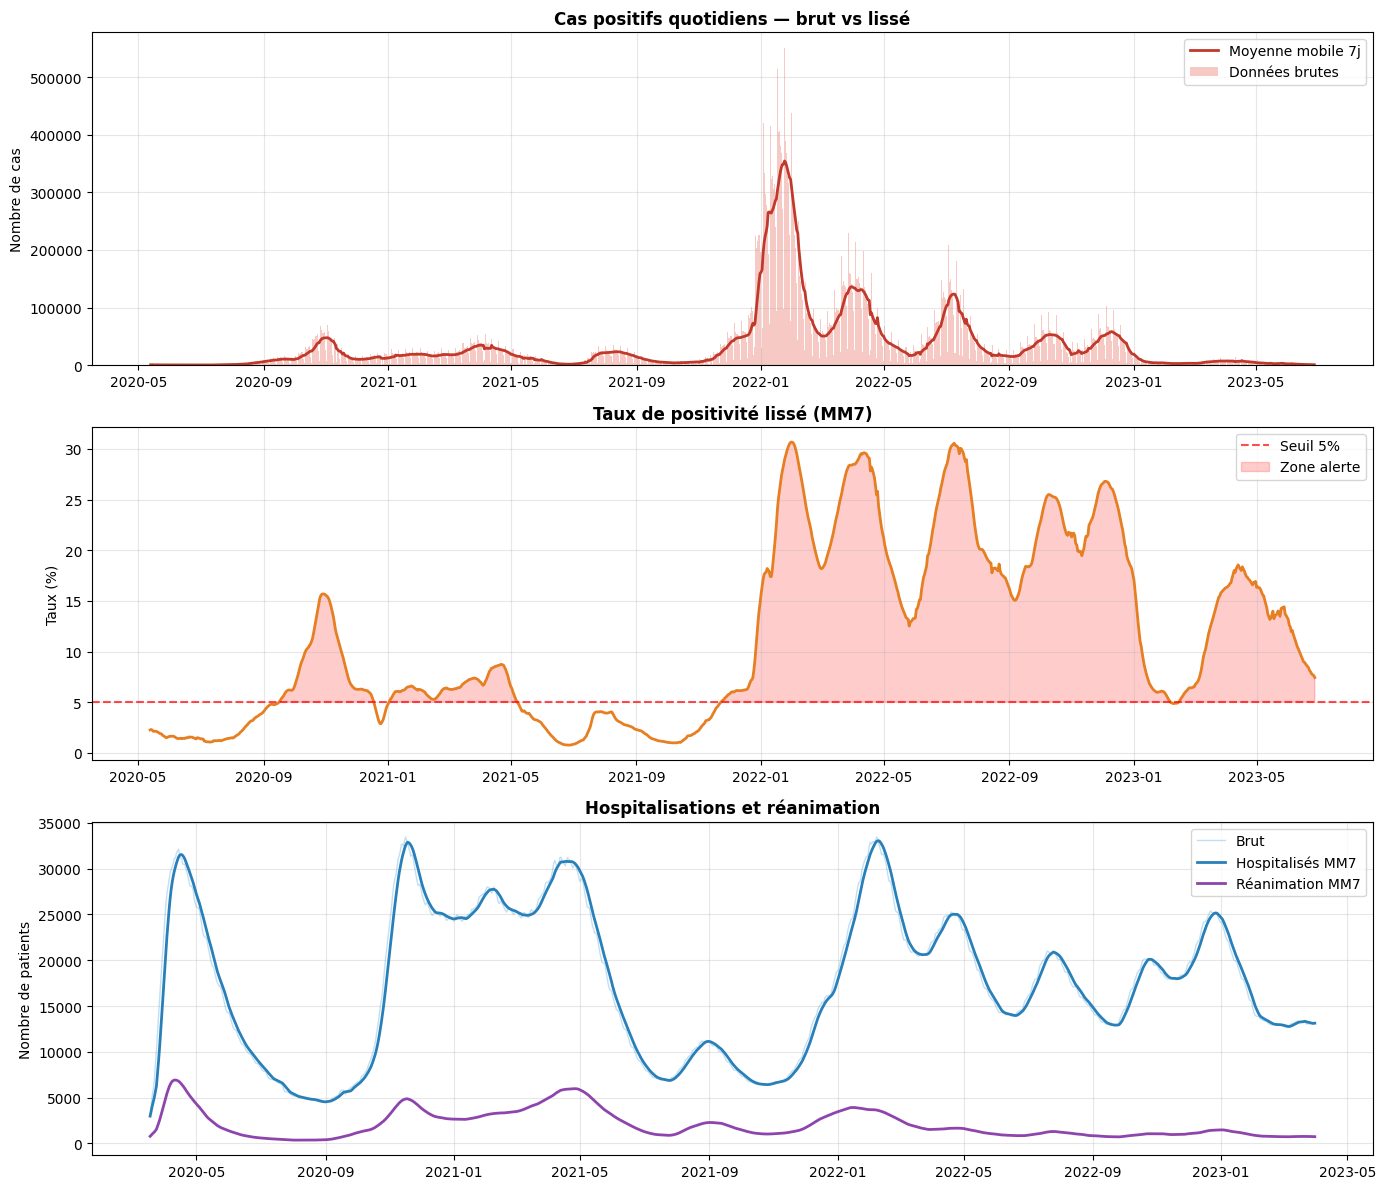

Graphique sauvegardé


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Graphique 1 — Cas positifs bruts vs moyenne mobile
axes[0].bar(tests_nat['jour'], tests_nat['cas_positifs'],
            color='#e74c3c', alpha=0.3, width=1, label='Données brutes')
axes[0].plot(tests_nat['jour'], tests_nat['cas_mm7'],
             color='#c0392b', linewidth=2, label='Moyenne mobile 7j')
axes[0].set_title('Cas positifs quotidiens — brut vs lissé', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Nombre de cas')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2 — Taux de positivité lissé
axes[1].plot(tests_nat['jour'], tests_nat['tp_mm7'],
             color='#e67e22', linewidth=2)
axes[1].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Seuil 5%')
axes[1].fill_between(tests_nat['jour'], tests_nat['tp_mm7'], 5,
                     where=tests_nat['tp_mm7'] > 5,
                     alpha=0.2, color='red', label='Zone alerte')
axes[1].set_title('Taux de positivité lissé (MM7)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Taux (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Graphique 3 — Hospitalisations
axes[2].plot(hosp_nat['jour'], hosp_nat['hospitalises'],
             color='#3498db', alpha=0.3, linewidth=1, label='Brut')
axes[2].plot(hosp_nat['jour'], hosp_nat['hosp_mm7'],
             color='#2980b9', linewidth=2, label='Hospitalisés MM7')
axes[2].plot(hosp_nat['jour'], hosp_nat['rea_mm7'],
             color='#8e44ad', linewidth=2, label='Réanimation MM7')
axes[2].set_title('Hospitalisations et réanimation', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Nombre de patients')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "assets" / "nettoyage_visualisation.png", dpi=150, bbox_inches='tight')
plt.show()
print("Graphique sauvegardé")

In [7]:
print("SAUVEGARDE DES DONNÉES NETTOYÉES")
print("=" * 50)

# Données par département (carte interactive)
df_tests.to_csv(PROCESSED_DATA / "tests_clean.csv", index=False)
df_hosp.to_csv(PROCESSED_DATA  / "hospitalisations_clean.csv", index=False)
df_vacc.to_csv(PROCESSED_DATA  / "vaccination_clean.csv", index=False)

# Données nationales agrégées (graphiques temporels)
tests_nat.to_csv(PROCESSED_DATA / "tests_national.csv", index=False)
hosp_nat.to_csv(PROCESSED_DATA  / "hospitalisations_national.csv", index=False)

print("Fichiers sauvegardés dans data/processed/ :")
for f in PROCESSED_DATA.iterdir():
    taille = f.stat().st_size / (1024 * 1024)
    print(f"   - {f.name} ({taille:.1f} Mo)")

SAUVEGARDE DES DONNÉES NETTOYÉES
Fichiers sauvegardés dans data/processed/ :
   - hospitalisations_clean.csv (3.2 Mo)
   - hospitalisations_national.csv (0.0 Mo)
   - tests_clean.csv (4.7 Mo)
   - tests_national.csv (0.1 Mo)
   - vaccination_clean.csv (5.2 Mo)
